In [1603]:
from display_utils import getHeader

<div style="font-size: 30px"><b>Data Sources</b></div>

<b>1.</b> This project uses the Global Landslide Catalog dataset exported from the NASA's Open Data Portal https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog-Export/dd9e-wu2v/about_data

As required by the host page, we cite the following two sources

<i>Kirschbaum, D. B., Adler, R., Hong, Y., Hill, S., & Lerner-Lam, A. (2010). A global landslide catalog for hazard applications: method, results, and limitations. Natural Hazards, 52(3), 561–575. doi:10.1007/s11069-009-9401-4. [1]</i>

<i>Kirschbaum, D.B., T. Stanley, Y. Zhou (In press, 2015). Spatial and Temporal Analysis of a Global Landslide Catalog. Geomorphology. doi:10.1016/j.geomorph.2015.03.016. [2]</i>

<b>2.</b> We will also use the GDP by country dataset obtained from https://github.com/datasets/gdp/blob/master/data/gdp.csv.


<div style="font-size: 30px"><b>Project Objectives</b></div>

<div style="font-size: 20px">We would like to understand the relationship between <b>casualties</b> (fatality_count and injury_count) and other variables from the datesets such as event time and country GDP in landslide events. We will use explorative data analysis and build interpretable regression models toward this goal.</div> 

<div style="border: 1px solid lightgrey; width: 90%"></div>

<div style="font-size: 30px"><b>Explorative Data Analysis</b></div>

In [1604]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [1605]:
landslide_data = pd.read_csv('landslide_data.csv')

In [1606]:
landslide_data.shape

(11033, 31)

<div style="font-size: 25px"><b>Data Cleaning and Formatting</b></div>

<div style="font-size: 20px"><b>Global Landslide Dataset</b></div>
We will start with the global landslide dataset

<div style="border: 1px solid lightgrey; width: 80%"></div>

<div style="font-size: 15px"><b>Convert event_date to pd.datetime</b></div>

In [1607]:
landslide_data['timestamp'] = pd.to_datetime(landslide_data['event_date'], format='%m/%d/%Y %H:%M:%S %p')

In [1608]:
landslide_data['hour'] = landslide_data['timestamp'].dt.hour

In [1609]:
landslide_data['year'] = landslide_data['timestamp'].dt.year

In [1610]:
landslide_data['month'] = landslide_data['timestamp'].dt.month

This contains the event time. We will drop other columns that contain this information.

In [1611]:
landslide_data = landslide_data.drop(['event_date', 'event_time'], axis=1)

In [1612]:
landslide_data.shape

(11033, 33)

In [1613]:
landslide_data.columns

Index(['source_name', 'source_link', 'event_id', 'event_title',
       'event_description', 'location_description', 'location_accuracy',
       'landslide_category', 'landslide_trigger', 'landslide_size',
       'landslide_setting', 'fatality_count', 'injury_count', 'storm_name',
       'photo_link', 'notes', 'event_import_source', 'event_import_id',
       'country_name', 'country_code', 'admin_division_name',
       'admin_division_population', 'gazeteer_closest_point',
       'gazeteer_distance', 'submitted_date', 'created_date',
       'last_edited_date', 'longitude', 'latitude', 'timestamp', 'hour',
       'year', 'month'],
      dtype='object')

<div style="font-size: 15px"><b>Add event_source column</b></div>

In [1614]:
landslide_data['source_name'].nunique()

3918

In [1615]:
source_name_count_df = landslide_data.groupby(['source_name']).size().sort_values(ascending=False).reset_index(name="count")
source_name_count_df.head(10)

,source_name,count
0,Oregon DOT,768
1,maps.google.com,104
2,thehimalayantimes,75
3,news.xinhuanet,74
4,newsinfo.inquirer,71
5,thejakartapost,59
6,ibnlive.in,57
7,Times of India,47
8,The Jakarta Post,46
9,The Himalayan Times,43


We will take only the 10 source_name's and create a new group 'others' for the rest

In [1616]:
major_sources = set(source_name_count_df['source_name'].iloc[:10])

In [1617]:
def getEventSource(row):
    source = 'Others'
    if row['source_name'] in major_sources:
        source = row['source_name']
    row['event_source'] = source
    return row
landslide_data = landslide_data.apply(getEventSource, axis=1)

In [1618]:
landslide_data['event_source'] = landslide_data['event_source'].astype('category')

In [1619]:
landslide_data[landslide_data['source_name'] == 'maps.google.com'].head(2)

,source_name,source_link,event_id,event_title,event_description,location_description,location_accuracy,landslide_category,landslide_trigger,landslide_size,...,submitted_date,created_date,last_edited_date,longitude,latitude,timestamp,hour,year,month,event_source
495,maps.google.com,http://maps.google.com.br/maps/ms?source=embed...,1680,"Rua Ceará, bairro Quitandinha",Rua Ceará - bairro Quitandinha Deslizamento c...,"Rua Ceará, bairro Quitandinha",exact,landslide,downpour,medium,...,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-43.2212,-22.5232,2010-04-06 12:00:00,12,2010,4,maps.google.com
517,maps.google.com,http://maps.google.com.br/maps/ms?source=embed...,1633,Morro da Mangueira,O mapa da devastação no Rio. Queda de barreir...,Morro da Mangueira,1km,mudslide,downpour,medium,...,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-43.2394,-22.9033,2010-04-06 12:00:00,12,2010,4,maps.google.com


We will drop source_name and source_link. The information from these two columns are represented in event_source.

In [1620]:
landslide_data = landslide_data.drop(['source_name', 'source_link'], axis=1)


In [1621]:
landslide_data.shape

(11033, 32)

<div style="font-size: 15px"><b>Landslide description with categorical variables</b> <span>(contain missing values. We will deal with them separately, see details below)</span></div>

We will convert a few variables that classify the landslide events in groups into categorical variables

In [1622]:
landslide_info_categoricals = ['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']

<b>Missing values</b>
<div>We will delete rows with missing values for landslide_category and landslide_size. For landslide_trigger, we will create a new group 'unknown' for the missing values. For landslide_setting, since there is already a class "unknown", we assign this value to the rows with missing landslide_setting.</div>

In [1623]:
landslide_data[['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']].isna().sum()

landslide_category     1
landslide_trigger     23
landslide_size         9
landslide_setting     69
dtype: int64

In [1624]:
landslide_data = landslide_data.dropna(subset = ['landslide_category'])

In [1625]:
landslide_data = landslide_data.dropna(subset = ['landslide_size'])

In [1626]:
landslide_data.loc[landslide_data['landslide_trigger'].isna(), 'landslide_trigger'] = 'unknown'

In [1627]:
landslide_data.loc[landslide_data['landslide_setting'].isna(), 'landslide_setting'] = 'unknown'

In [1628]:
landslide_data[['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']].isna().sum()

landslide_category    0
landslide_trigger     0
landslide_size        0
landslide_setting     0
dtype: int64

In [1629]:
for column in landslide_info_categoricals:
    landslide_data[column] = landslide_data[column].astype('category')

<div style="font-size: 15px"><b>fatality_count</b></div>

In [1630]:
landslide_data[['fatality_count']].isna().sum()

fatality_count    1383
dtype: int64

In [1631]:
landslide_data = landslide_data.dropna(subset = ['fatality_count'])

landslide_data['fatality_count'].describe()

<Axes: xlabel='fatality_count', ylabel='Density'>

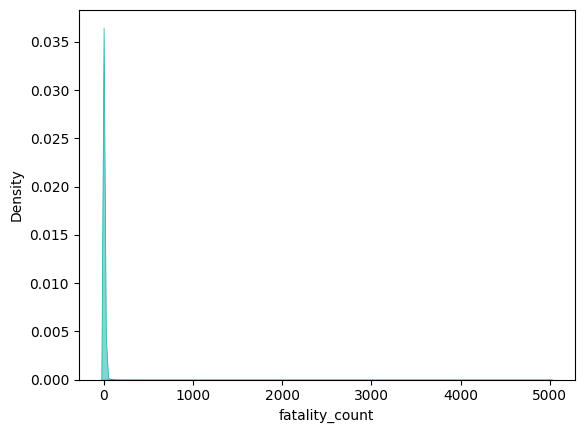

In [1632]:
fig, ax = plt.subplots()
sns.kdeplot(landslide_data['fatality_count'], ax=ax, fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

<b>There are outliers to the right having extremely big values. This skews the distribution. The values seem to be correct and we will keep the outliers as they may represent underlying structures in the true distribution. </b>

In [1633]:
landslide_data[landslide_data['fatality_count'] > 1000].size

96

In [1634]:
landslide_data_without_outliers = landslide_data[np.abs(landslide_data["fatality_count"]-landslide_data["fatality_count"].mean())<=(3*landslide_data["fatality_count"].std())] 

In [1635]:
landslide_data['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

In [1636]:
landslide_data.columns

Index(['event_id', 'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude',
       'timestamp', 'hour', 'year', 'month', 'event_source',
       'log_fatality_count'],
      dtype='object')

In [1637]:
landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

/var/folders/65/_pqxxk_n1sl_p8w5kyxhrm640000gp/T/ipykernel_56371/1082021034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)


<Axes: xlabel='log_fatality_count', ylabel='Density'>

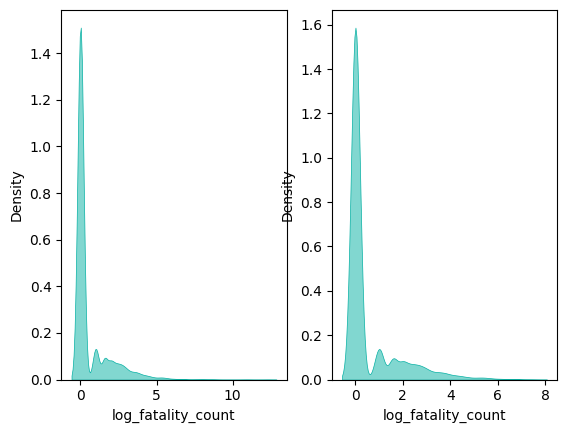

In [1638]:
fig, axes = plt.subplots(ncols=2, nrows=1)
sns.kdeplot(landslide_data['log_fatality_count'], ax=axes[0], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')
sns.kdeplot(landslide_data_without_outliers['log_fatality_count'], ax=axes[1], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

In [1639]:
landslide_data.shape
# landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

(9640, 33)

<b>injury_count</b>

<Axes: xlabel='injury_count', ylabel='Density'>

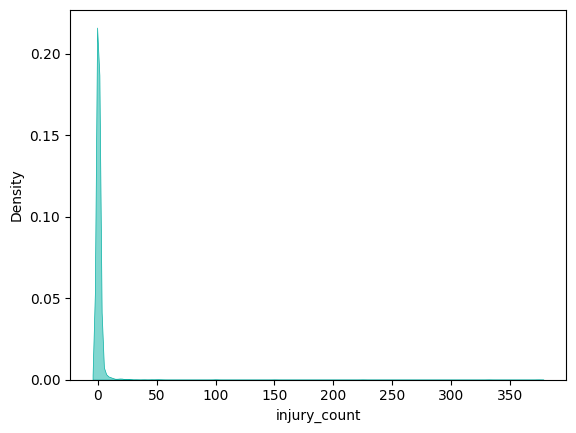

In [1640]:
fig, ax = plt.subplots()
sns.kdeplot(landslide_data['injury_count'], ax=ax, fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

In [1641]:
landslide_data['log_injury_count'] = np.log2(landslide_data['injury_count'] + 1)

<Axes: xlabel='log_injury_count', ylabel='Density'>

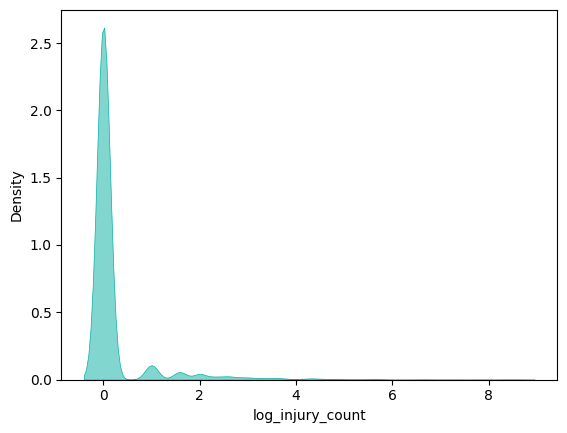

In [1642]:
fig, ax = plt.subplots()
sns.kdeplot(landslide_data['log_injury_count'], ax=ax, fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

<b>Same as for fatality_count, we will keep the outliers</b>

<div style="font-size: 15px"><b>Select Columns to Use</b></div>


<b>A note for the choice of country_name over country_code: we will be joining the gdp data with the landslide data. It seems that the country code in the two tables are computed according to different conventions and they don't match for most countries. On the other handm, country name is consistent between the two tables.</b>

In [1643]:
used_columns = ['year', 'hour', 'month', 'event_source', 'landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting', 'fatality_count', 'log_fatality_count', 'injury_count', 'log_injury_count', 'country_name', 'longitude', 'latitude']

In [1644]:
landslide_data = landslide_data[used_columns]

In [1645]:
landslide_data.shape

(9640, 15)

<div style="font-size: 15px"><b>Missing Values in country_name</b></div>
For missing country_code values, we will create a new class unknown.

In [1646]:
def assign_missing_country_name(row):
    if pd.isna(row['country_name']):
        row['country_name'] = 'unknown'
    return row
landslide_data = landslide_data.apply(assign_missing_country_name, axis=1)

<div style="font-size: 20px"><b>Country GDP Dataset</b></div>
We will now turn to the country GDP dataset

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1647]:
gdp_data = pd.read_csv('gdp_country.csv')

In [1648]:
gdp_data = pd.melt(gdp_data, id_vars=['Country Name'], value_vars=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'])

In [1649]:
gdp_data = gdp_data.rename(columns={'Country Name': 'country_name', 'variable': 'year'})

In [1650]:
gdp_data['year'] = pd.to_numeric(gdp_data['year'])

In [1651]:
landslide_data = landslide_data.merge(gdp_data, on=['country_name', 'year'], how='left' )

In [1652]:
landslide_data = landslide_data.rename(columns={'value': 'gdp'})

In [1653]:
landslide_data['gdp'].isna().sum()

np.int64(1837)

<b>We will fill the missing GDP with the mean.</b>

In [1654]:
landslide_data['gdp'] = landslide_data['gdp'].fillna(landslide_data['gdp'].mean())

In [1655]:
landslide_data['gdp'].isna().sum()

np.int64(0)

<div style="font-size: 20px"><b>Split full data for different objectives</b></div>
Our target variables are fatality_count and injury_count. We will split the full data into two dataframes for predicting each, respectively.

In [1656]:
landslide_injury_data = landslide_data[landslide_data['injury_count'].notna()]

In [1657]:
landslide_fatality_data = landslide_data[landslide_data['fatality_count'].notna()]

For predicting injury_count, we will use fatality_count to impute values for landslide_size

<div style="font-size: 20px"><b>Missing values for landslide_size</b></div>
Since landslide_size is an ordinal categorical variable, we want to convert to numeric. For this, note that, even though we have dropped all rows with null landslide_size, there is one class called unknown, which cannot be taken into account when convert all values to numeric. 
<div></div>
Therefore, we will view the unknown values as null and impute them. We will do it separately for landslide_injury_data and landslide_fatality_data. We will define a general function to do this.

In [1658]:

  
def get_landslide_size(data, compare_column):
    compare_column_avg = data.groupby('landslide_size')[compare_column].mean()
    compare_column_avg_dict = compare_column_avg.to_dict()
    del compare_column_avg_dict['unknown']
    compare_column_avg_to_size = {avg: c for c, avg in compare_column_avg_dict.items()}
    sorted_avg = sorted(compare_column_avg_to_size.keys())
    index = (data['landslide_size'] == 'large') | (data['landslide_size'] == 'catastrophic')
    def find_size_lass(compare_column_count):
        closest_ind = bisect.bisect_left(sorted_avg, compare_column_count)
        size_class = compare_column_avg_to_size[sorted_avg[closest_ind]]
        return size_class
    def get_size(row):
        size = row['landslide_size']
        if size == 'unknown':
            size = find_size_lass(row['injury_count'])
        avg = compare_column_avg_dict[size]
        row['landslide_size'] = sorted_avg.index(avg)
        return row   
    data = data.apply(get_size, axis=1)
    return data
    
 

In [1659]:
landslide_fatality_data = get_landslide_size(landslide_fatality_data, 'fatality_count')

In [1660]:
landslide_injury_data = get_landslide_size(landslide_injury_data, 'injury_count')

<div style="font-size: 20px"><b>Final Data and Variables Selection</b></div>

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1661]:
landslide_fatality_data = landslide_fatality_data.drop(['fatality_count', 'country_name', 'injury_count', 'log_injury_count'], axis=1)

In [1662]:
landslide_injury_data = landslide_injury_data.drop(['fatality_count', 'log_fatality_count', 'country_name', 'injury_count'], axis=1)

In [1663]:
landslide_fatality_data.columns

Index(['year', 'hour', 'month', 'event_source', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'log_fatality_count', 'longitude', 'latitude', 'gdp'],
      dtype='object')

In [1664]:
landslide_injury_data.columns

Index(['year', 'hour', 'month', 'event_source', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'log_injury_count', 'longitude', 'latitude', 'gdp'],
      dtype='object')

<div style="font-size: 25px"><b>Data Visualization</b></div>

<div style="font-size: 20px"><b>Numeric Variables Distributions</b></div> 

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1665]:
numeric_columns = ['longitude', 'latitude', 'gdp']

In [1666]:
def get_dist_numeric(col, landslide_fatality_data, landslide_injury_data):
    fig, axes = plt.subplots(1, 3, figsize=(16, 10))
    sns.kdeplot(full_data[col], ax=axes[0], fill=True, alpha=0.5, linewidth=0.5, color='#4D9DFF')
    sns.regplot(x=col, y="log_fatality_count", data=landslide_fatality_data,ax=axes[1], line_kws=dict(color='y'))
    sns.regplot(x=col, y="log_injury_count", data=landslide_injury_data,ax=axes[2], line_kws=dict(color='y'))
    axes[0].set_title('distribution')
    axes[1].set_title('relationship with log_fatality_count and log_injury_count')

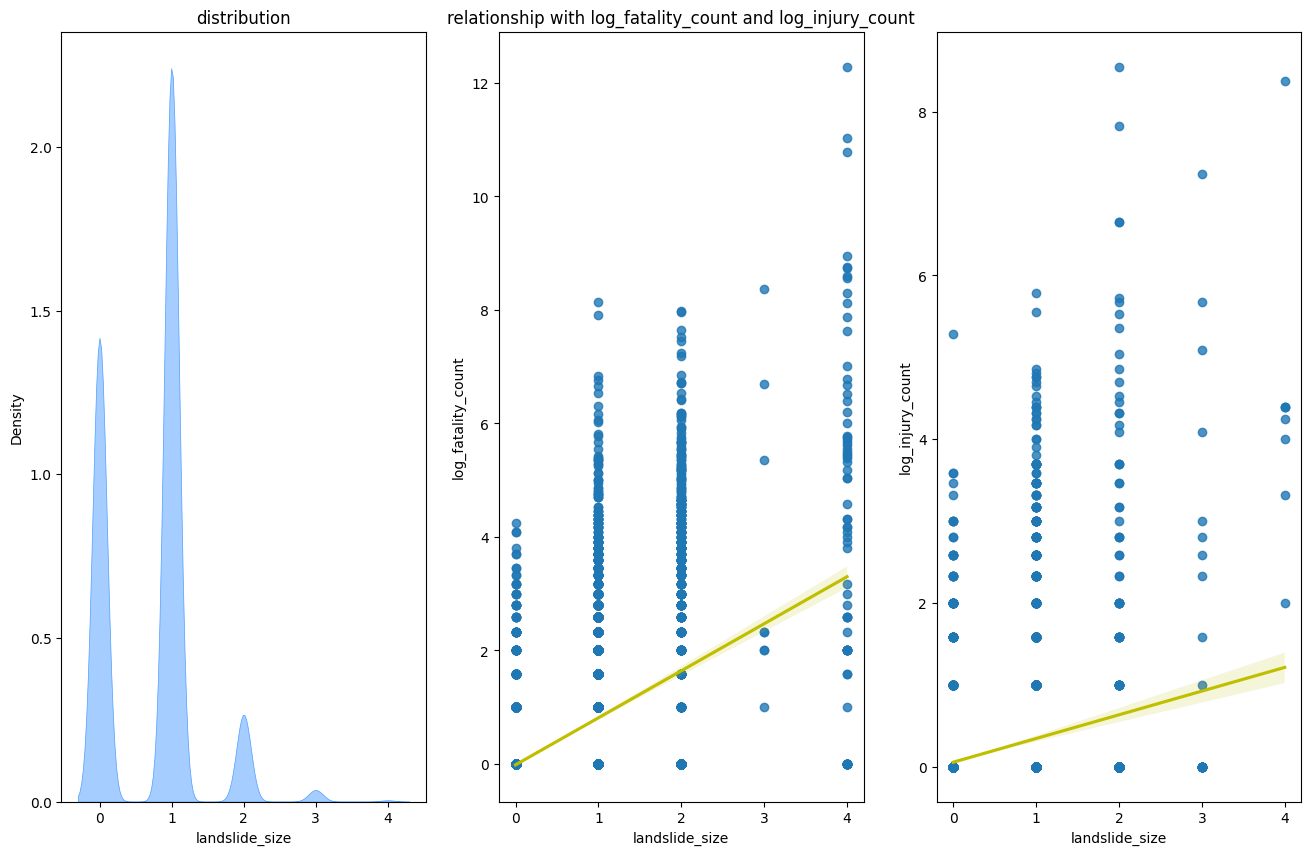

In [1667]:
get_dist_numeric('landslide_size', landslide_fatality_data, landslide_injury_data)

Both fatality_count and injury_count are clearly positively correlated with landslide_size.

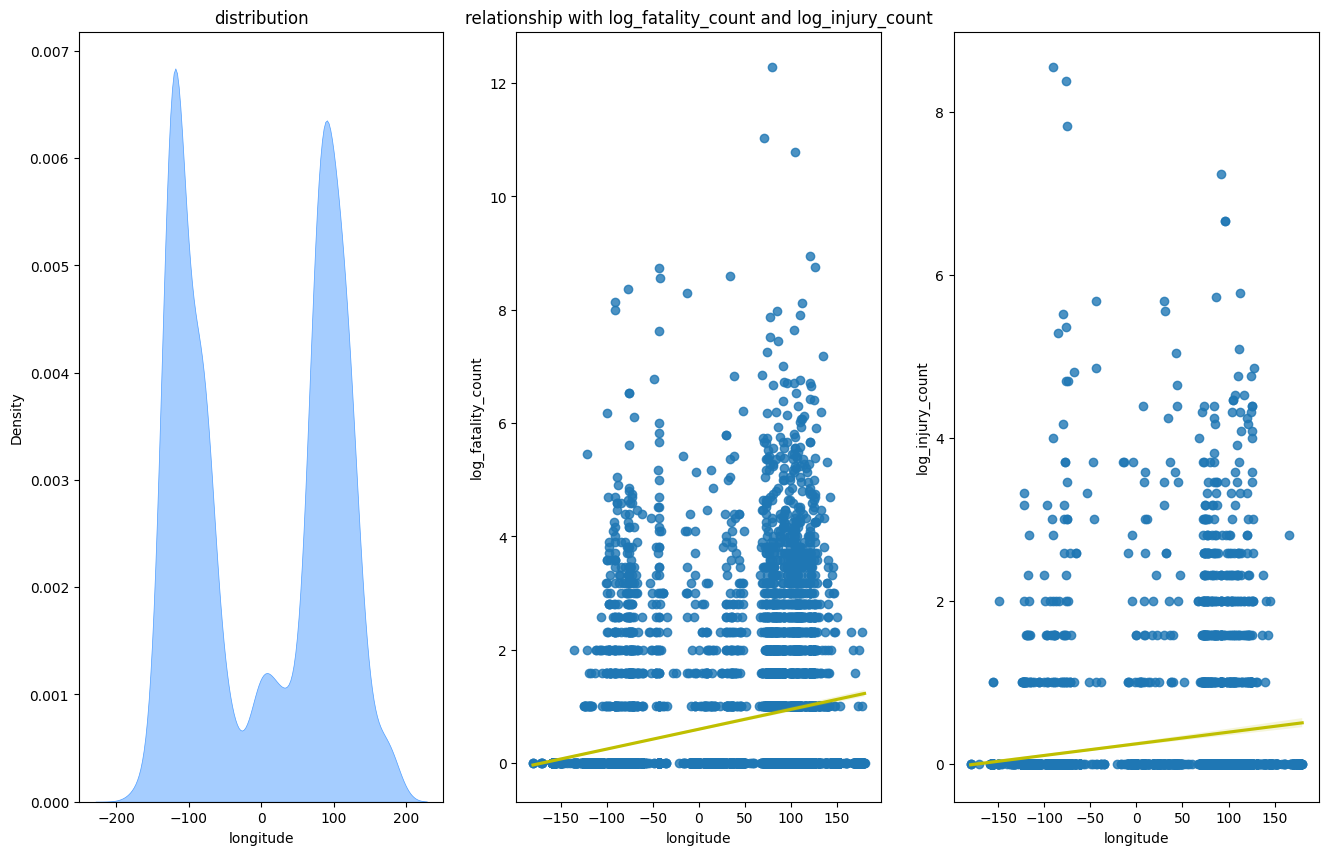

In [1668]:
get_dist_numeric('longitude',landslide_fatality_data, landslide_injury_data)

longitude does not seem to be very informative.

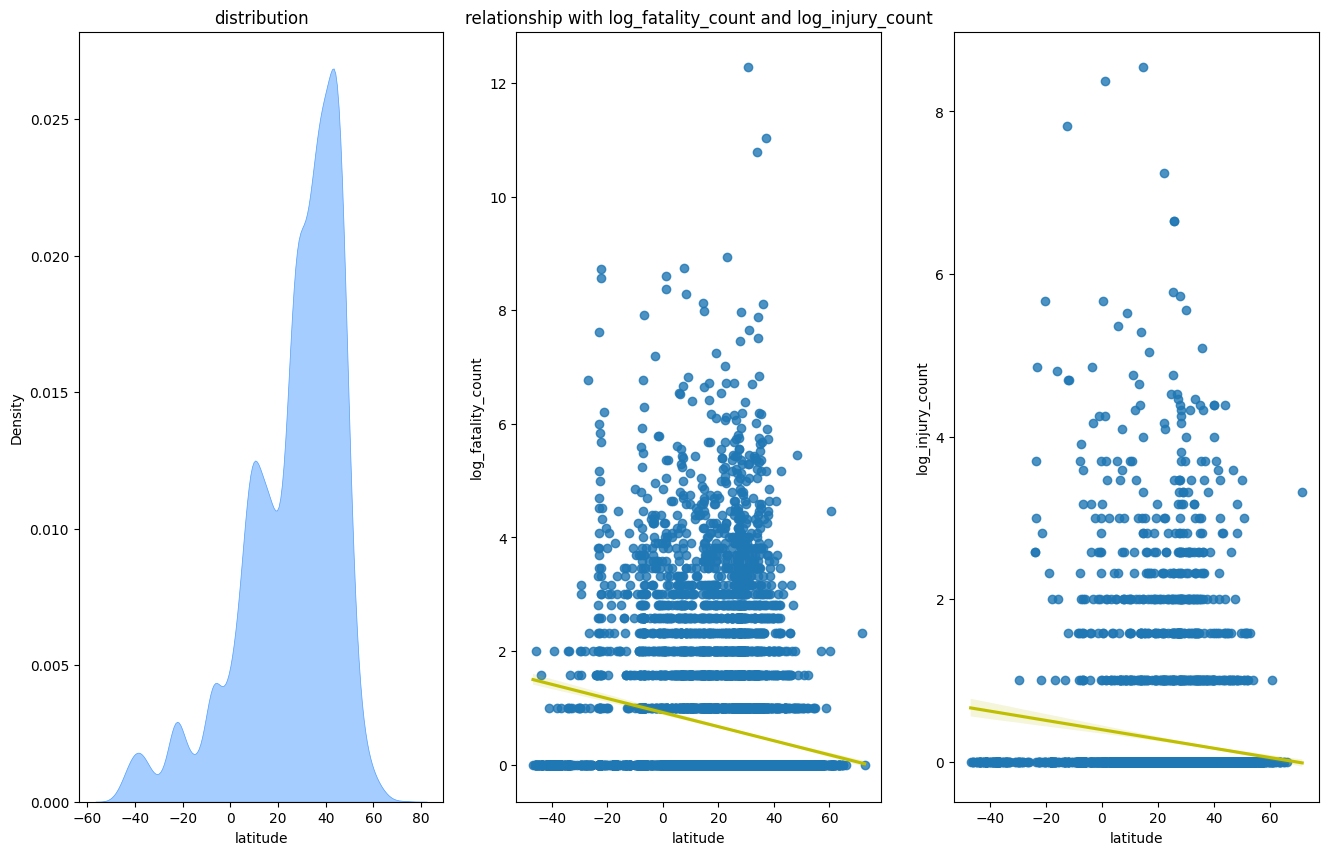

In [1669]:
get_dist_numeric('latitude', landslide_fatality_data, landslide_injury_data)

latitude does not seem to be very informative.

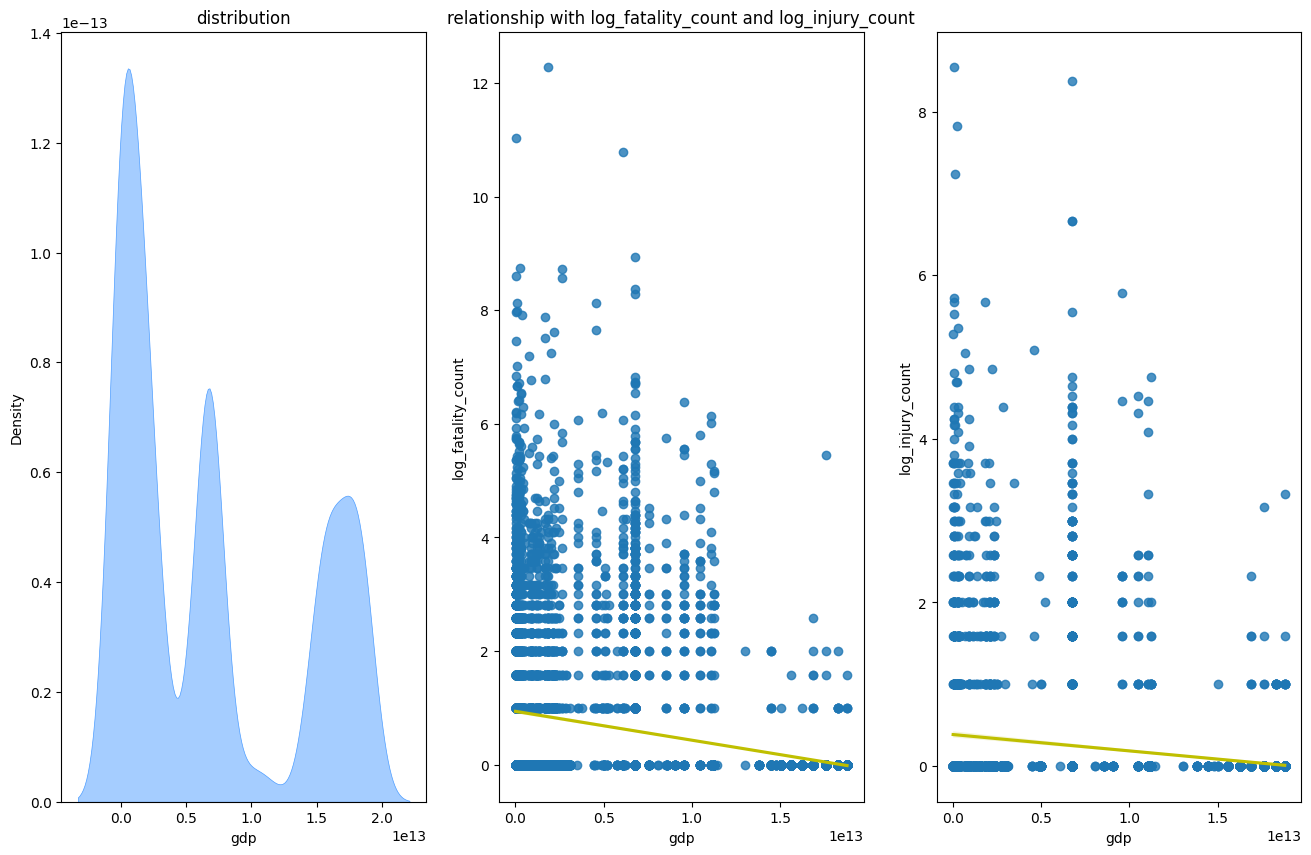

In [1670]:
get_dist_numeric('gdp', landslide_fatality_data, landslide_injury_data)

The relationship between fatality and the GDP of the country where the event occurred shown in the second graph is intuitive. A higher GDP indicates a more developed state which means a better safty and medical measures to reduce casualty.  

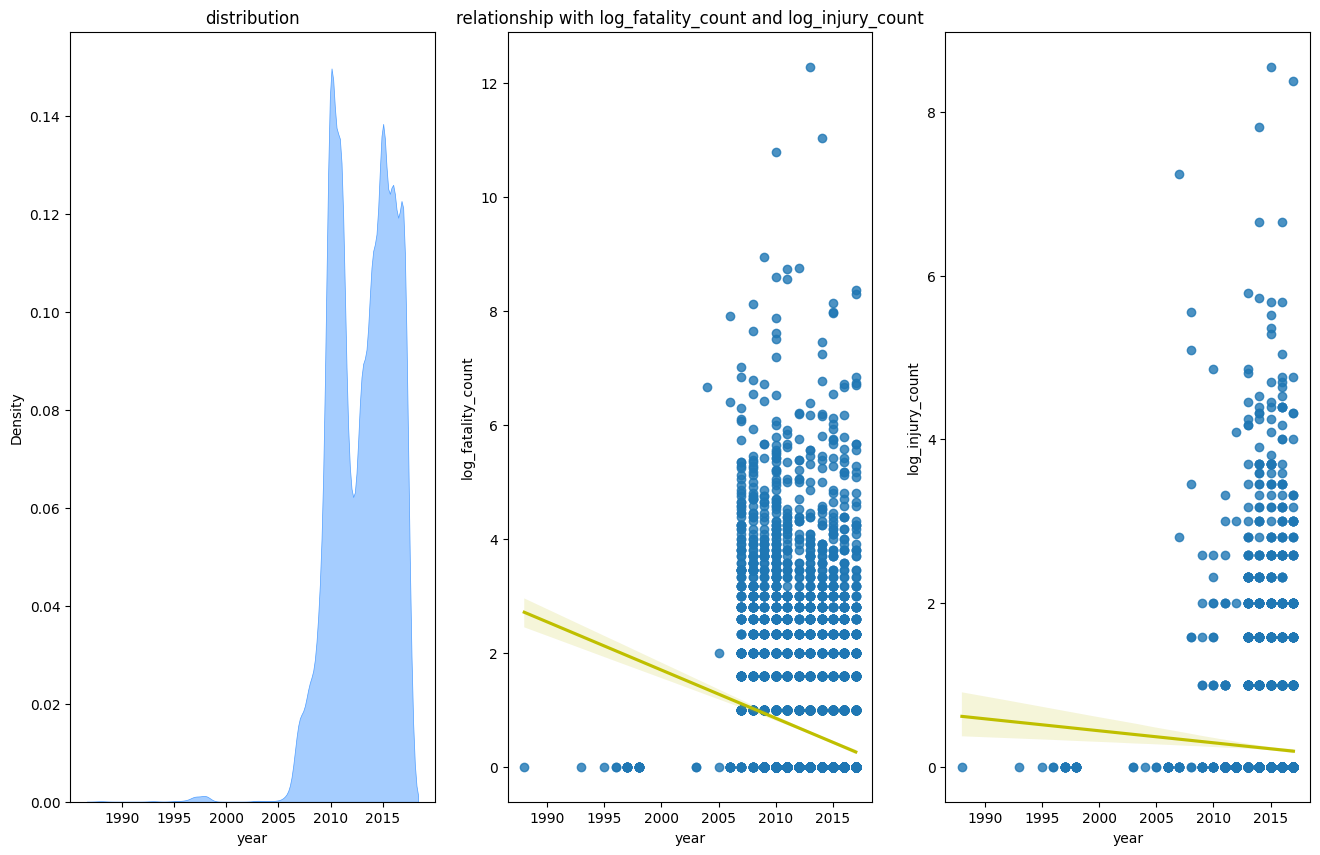

In [1671]:
get_dist_numeric('year', landslide_fatality_data, landslide_injury_data)

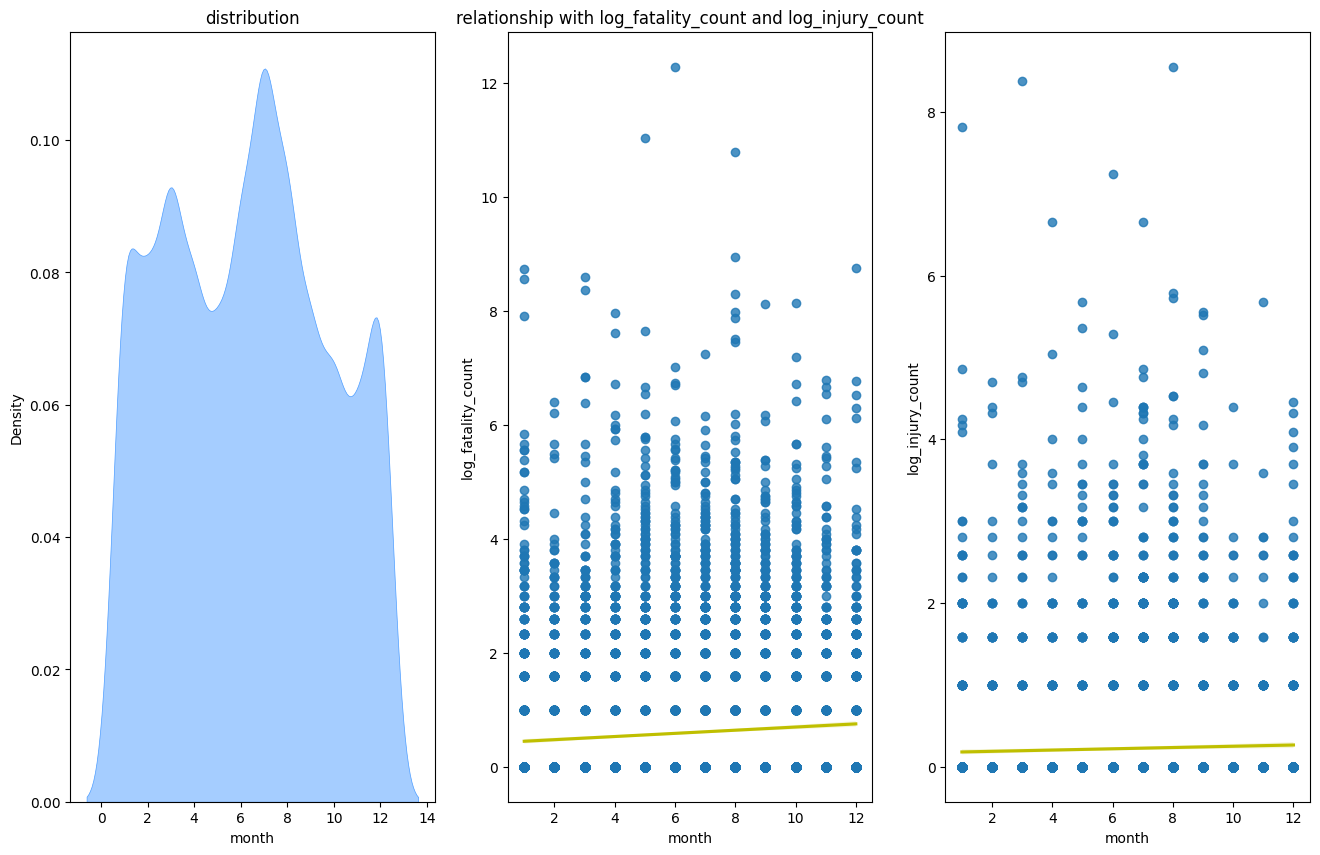

In [1672]:
get_dist_numeric('month', landslide_fatality_data, landslide_injury_data)

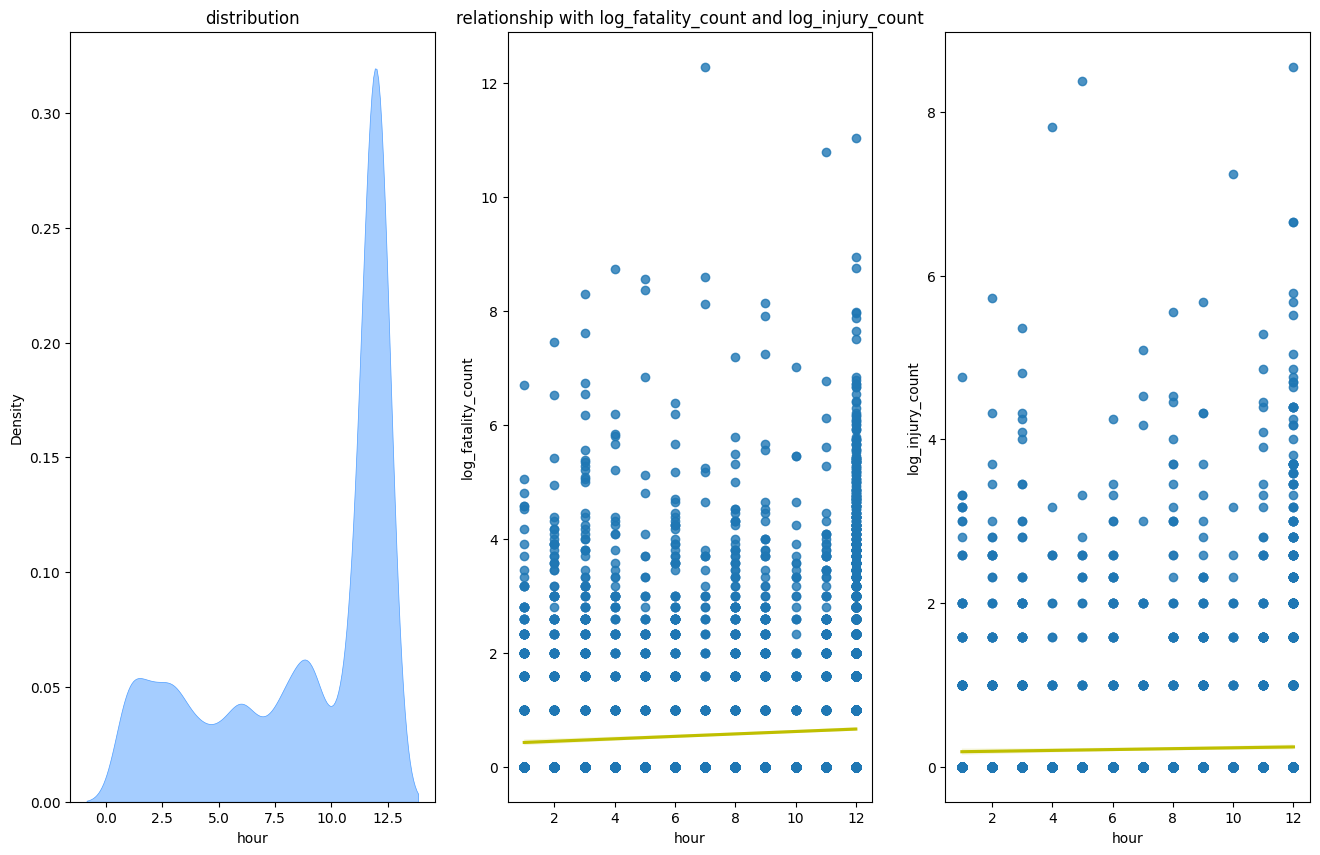

In [1673]:
get_dist_numeric('hour', landslide_fatality_data, landslide_injury_data)

None of the time variables seem to provide a lot of information on casualty, which is rather surprising.

<div style="font-size: 20px"><b>Categorical Variables Distributions</b></div> 

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1674]:
categorical_columns = ['event_source', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting']

In [1675]:
def get_categorical_column_dist(col, landslide_fatality_data, landslide_injury_data):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    fig.set_size_inches(12, 12)
    ax1 = axes[0][0]
    df_sort = landslide_fatality_data.groupby(col)['log_fatality_count'].mean().sort_values(ascending=False).index
    sns.barplot(x='log_fatality_count', y=col, data=landslide_fatality_data, color='#4D9DFF', order=df_sort,
                estimator=np.mean, errorbar=None, err_kws={'linewidth': 0}, ax=ax1)
    for p in ax1.patches:
        ax1.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2. + 0.3, p.get_y() + p.get_height() + 0.2),
                    ha='center', va='center', xytext=(0, 20), textcoords='offset points', fontsize=10, color='black')
    ax1.set_title(f'Mean log_fatality_count by {col}')
    ax1.set_xlabel('log_fatality_count')
    ax1.set_ylabel('')
    sns.despine(left=True, bottom=True, ax=ax1)
    
    ax2 = axes[0][1]
    sns.violinplot(x='log_fatality_count', y=col, data=landslide_fatality_data, color='#4D9DFF', order=df_sort, ax=ax2)
    ax2.set_title(f'Distribution of log_fatality_count by {col}')
    ax2.set_ylabel("")
    sns.despine(left=True, bottom=True, ax=ax2)

    ax3 = axes[1][0]
    df_sort = landslide_injury_data.groupby(col)['log_injury_count'].mean().sort_values(ascending=False).index
    sns.barplot(x='log_injury_count', y=col, data=landslide_injury_data, color='#4D9DFF', order=df_sort,
                estimator=np.mean, errorbar=None, err_kws={'linewidth': 0}, ax=ax3)
    for p in ax3.patches:
        ax3.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2. + 0.2, p.get_y() + p.get_height() + 0.2),
                    ha='center', va='center', xytext=(0, 20), textcoords='offset points', fontsize=10, color='black')
    ax3.set_title(f'Mean log_injury_count by {col}')
    ax3.set_xlabel('log_injury_count')
    ax3.set_ylabel('')
    sns.despine(left=True, bottom=True, ax=ax3)
    
    ax4 = axes[1][1]
    sns.violinplot(x='log_injury_count', y=col, data=landslide_injury_data, color='#4D9DFF', order=df_sort, ax=ax4)
    ax4.set_title(f'Distribution of log_injury_count by {col}')
    ax4.set_ylabel("")
    sns.despine(left=True, bottom=True, ax=ax4)
    plt.tight_layout()
    
    plt.show()

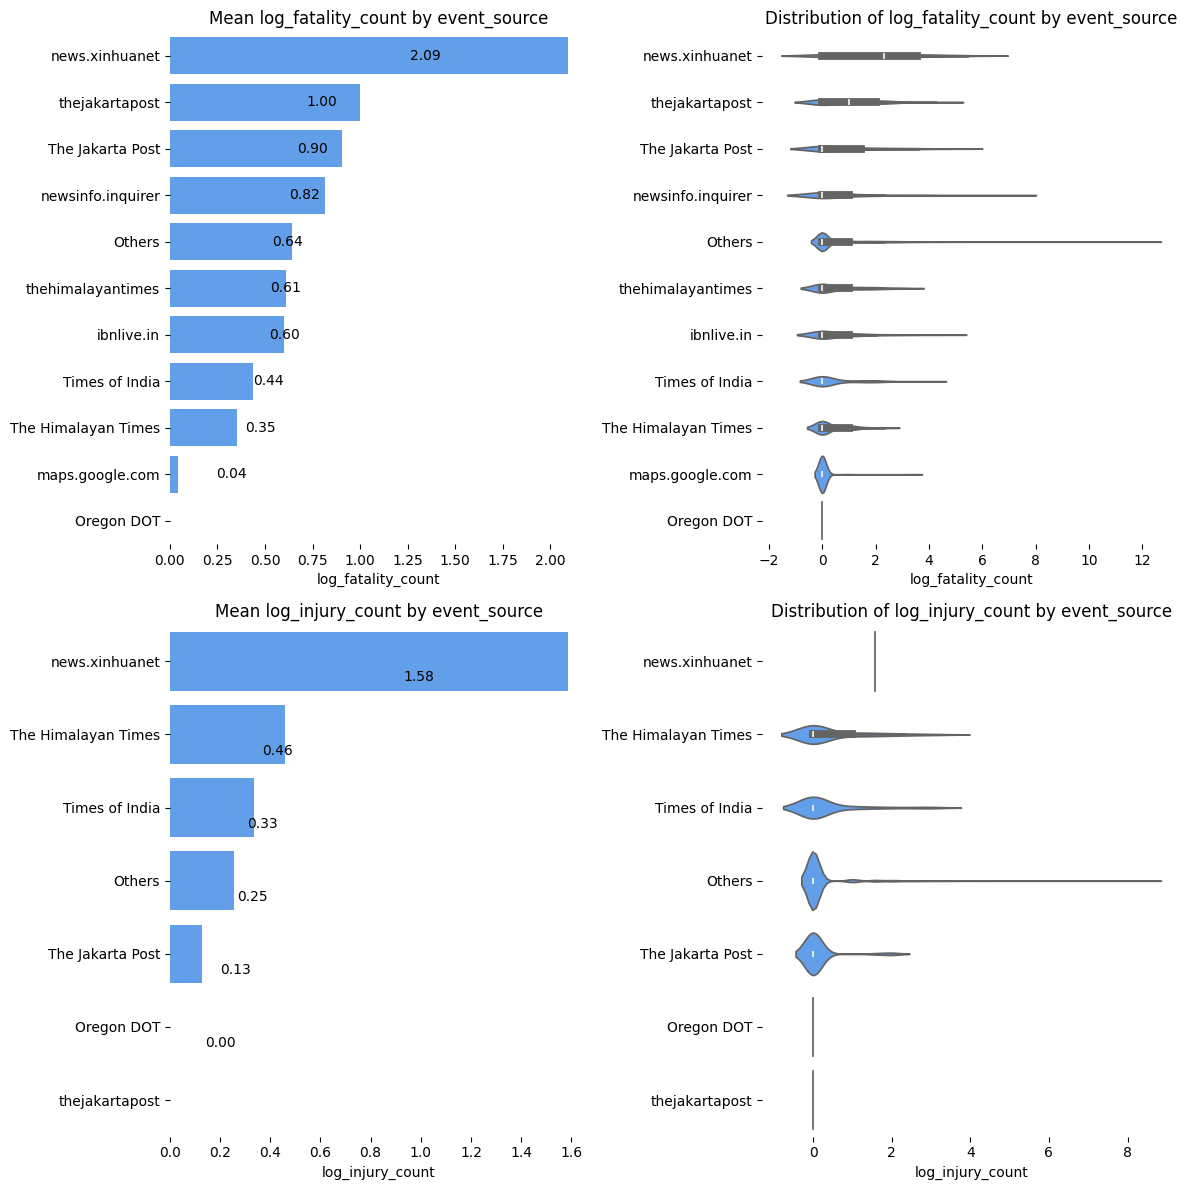

In [1676]:
get_categorical_column_dist('event_source', landslide_fatality_data, landslide_injury_data)

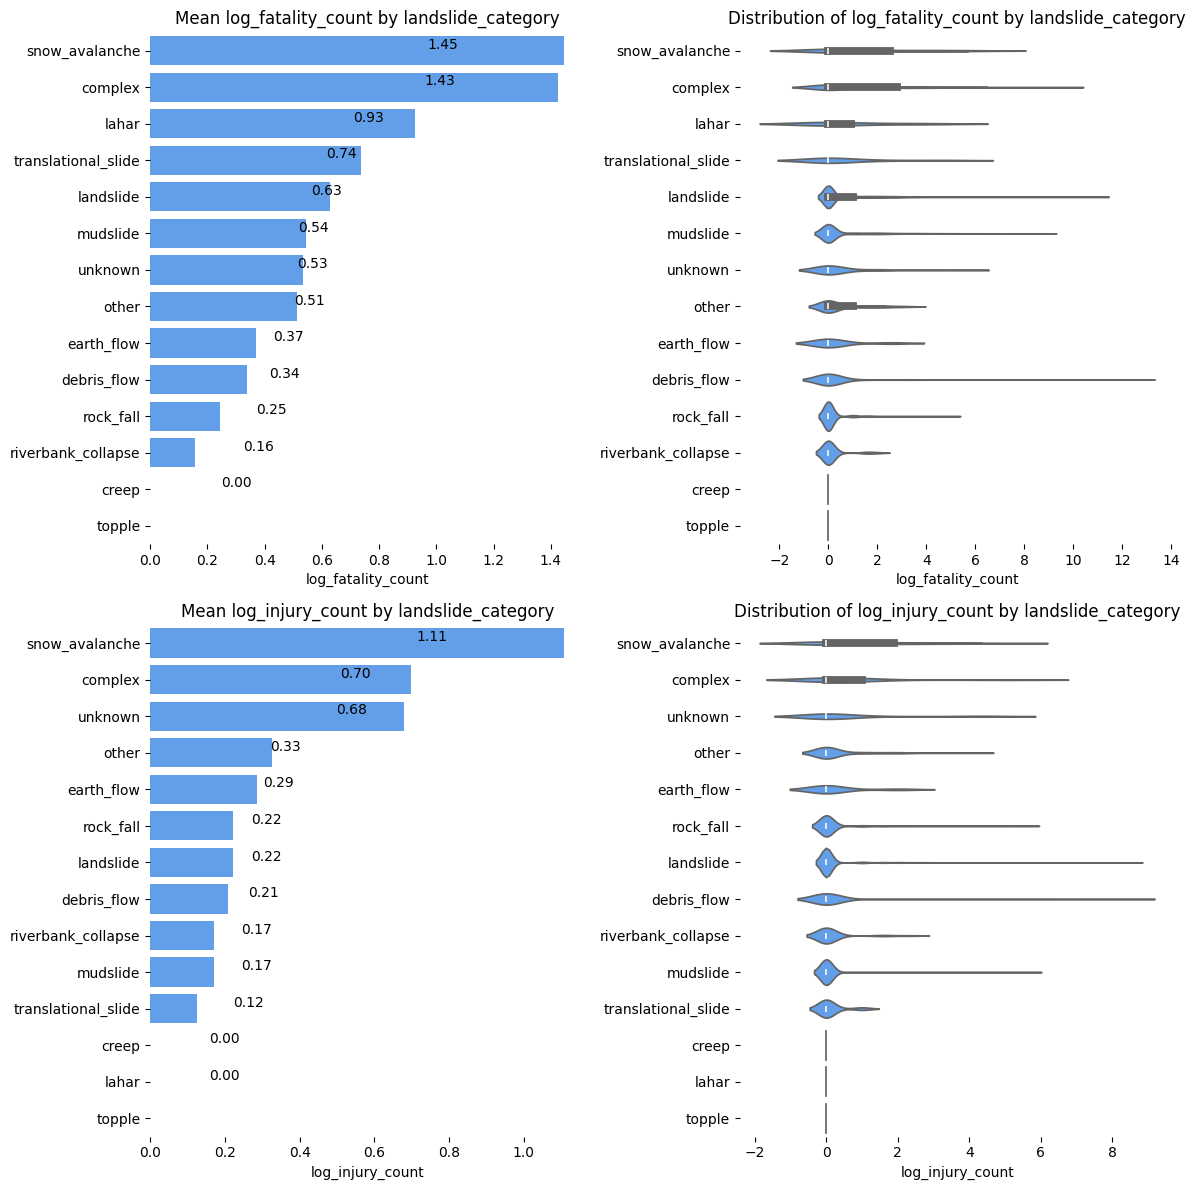

In [1677]:
get_categorical_column_dist('landslide_category', landslide_fatality_data, landslide_injury_data)

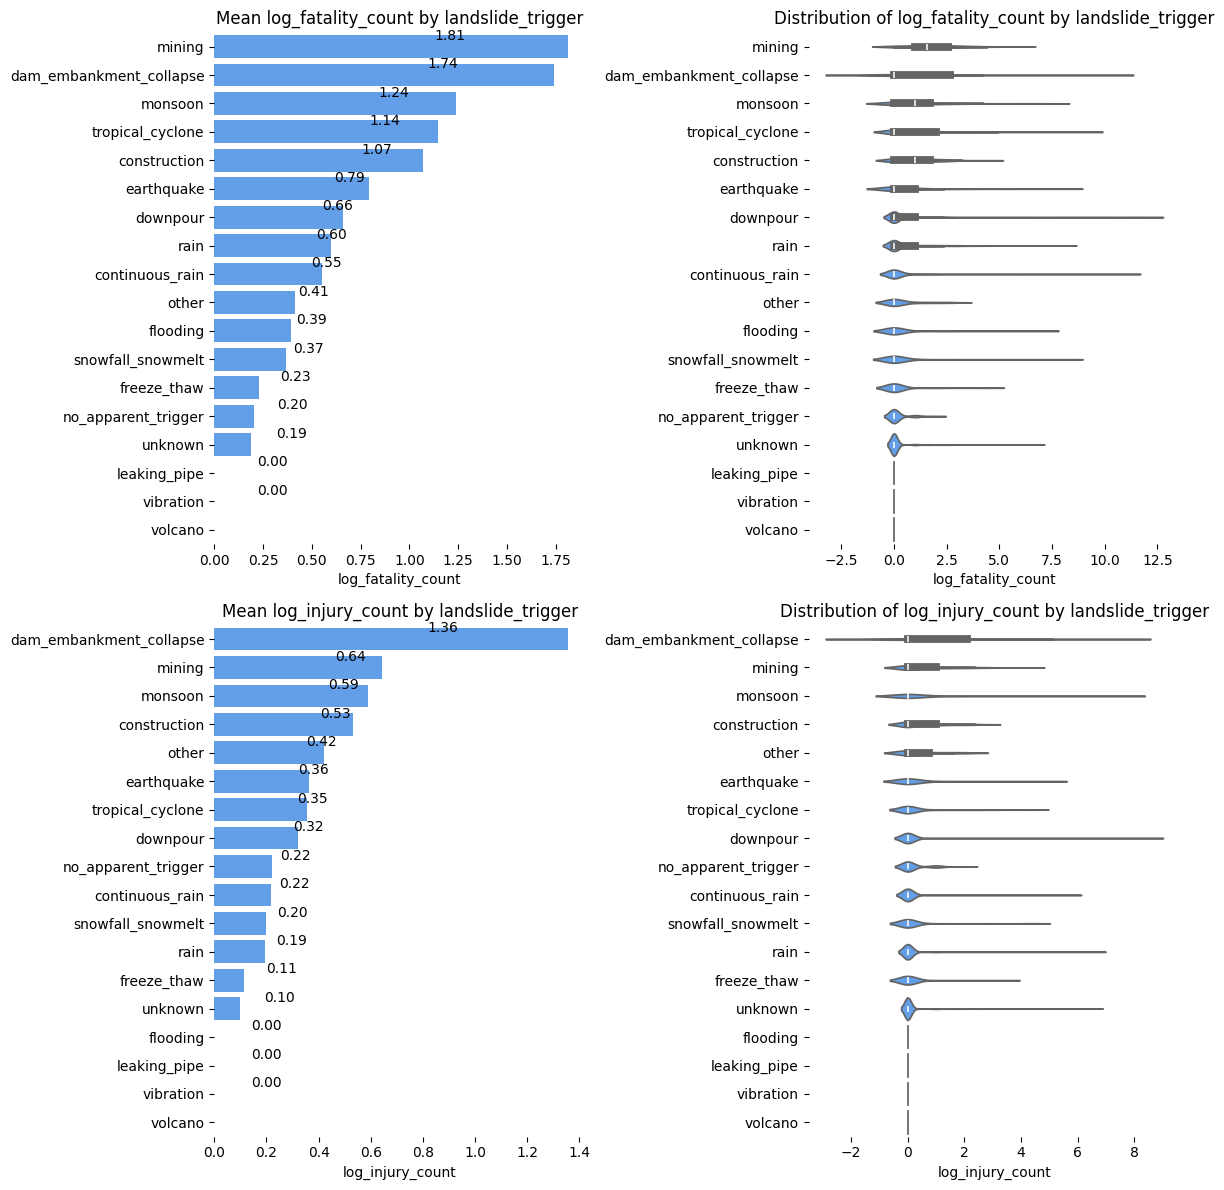

In [1678]:
get_categorical_column_dist('landslide_trigger', landslide_fatality_data, landslide_injury_data)

It is not clear from the source of the Global Landslide Catelog how landslide_size is determined. It is based on factors like infrastructure damage and area of affected region, then it is worth to keep it as a predictor.

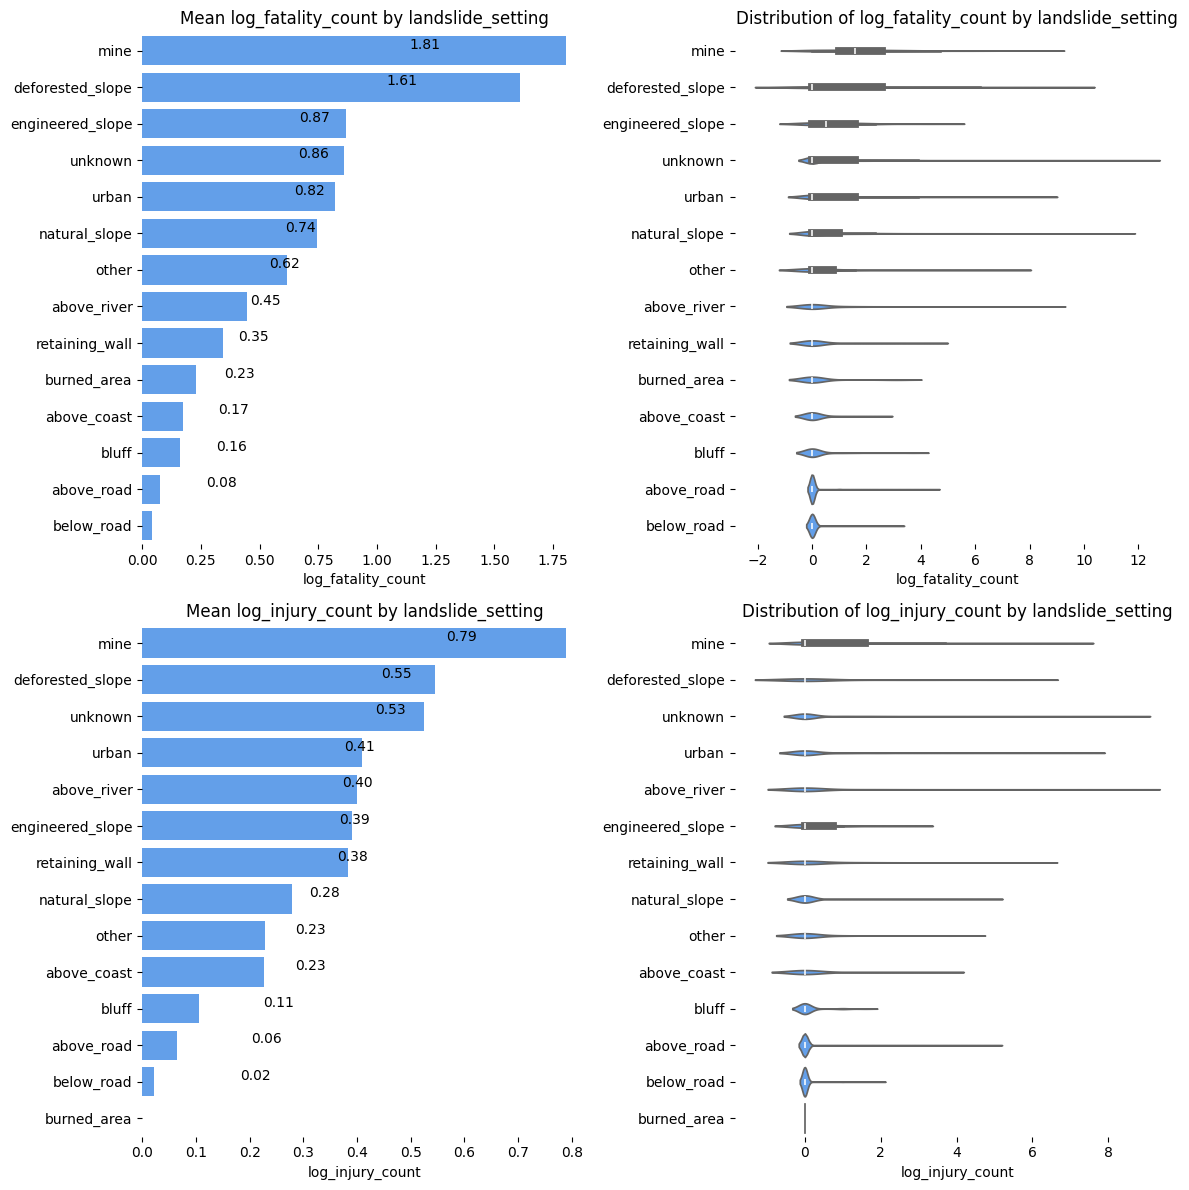

In [1679]:
get_categorical_column_dist('landslide_setting', landslide_fatality_data, landslide_injury_data)

Among the different settings, mine and deforested_slope are associated with much higher fatality_count


<div style="border: 1px solid lightgrey; width: 90%"></div>

<div style="font-size: 30px"><b>Models</b></div>

In [1684]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer

In [1685]:
X_fatality = landslide_fatality_data.drop(['log_fatality_count'], axis=1)
y_fatality = landslide_fatality_data['log_fatality_count']

In [1686]:
X_injury = landslide_injury_data.drop(['log_injury_count'], axis=1)
y_injury = landslide_injury_data['log_injury_count']

<div style="font-size: 15px"><b>Convert categorical variables to indicator variables</b></div>

In [1687]:
categorical_variables = ['event_source', 'landslide_category', 'landslide_trigger', 'landslide_setting']
X_fatality = pd.get_dummies(X_fatality, columns=categorical_variables, drop_first=True)
X_injury = pd.get_dummies(X_injury, columns=categorical_variables, drop_first=True)

Since the values of GDP are large, we need to scale the columns

In [1689]:
normalized_X_fatality = (X_fatality - X_fatality.mean())/X_fatality.std()

In [1697]:
normalized_X_injury = (X_injury - X_injury.mean())/X_injury.std()

In [1714]:
X_fatality_train, X_fatality_test, y_fatality_train, y_fatality_test = train_test_split(normalized_X_fatality, y_fatality, test_size=0.2, random_state=42)

In [1715]:
X_injury_train, X_injury_test, y_injury_train, y_injury_test = train_test_split(normalized_X_injury, y_injury, test_size=0.2, random_state=42)

In [1716]:
X_injury_train.shape

(4274, 56)

<div style="font-size: 25px"><b>Linear Models</b></div>

In [1717]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

<div style="font-size: 20px"><b>Linear Regression</b></div>
We will start with the linear regression model


<div style="border: 1px solid lightgrey; width: 90%"></div>

In [1721]:
def get_linear_model(X_train, y_train, X_test, y_test):
    linear_model = LinearRegression()
    linear_model.fit(X = X_train,y = y_train)
    y_train_preds = linear_model.predict(X_train)
    print('training R^2', r2_score(y_train, y_train_preds))
    y_test_preds = linear_model.predict(X_test)
    print('test R^2', r2_score(y_test, y_test_preds))
    return linear_model

In [1722]:
print('linear regression results for fatality_count')
get_linear_model(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test)

linear regression results for fatality_count
training R^2 0.299436483802875
test R^2 0.2388922854626896


LinearRegression()

In [1723]:
print('linear regression results for injury_count')
get_linear_model(X_injury_train, y_injury_train, X_injury_test, y_injury_test)

linear regression results for injury_count
training R^2 0.13011830815782943
test R^2 0.13283373639992813


LinearRegression()

We have seen that the distributions of both fatality_count and injury_count have 2 apparent modes (local maxima) and is right skewed. Not surprisingly, linear regression does not give a good fit.

<b>We now look linear models with regularization.</b>

In [1736]:
r2_scorer = make_scorer(r2_score, greater_is_better=True)

<div style="font-size: 20px"><b>Ridge Regression</b></div>

In [1733]:

def get_ridge_model(X_train, y_train, X_test, y_test, scorer):
    ridge_model = Ridge()
    ridge_params = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
    grid_ridge_models = GridSearchCV(ridge_model,
                          ridge_params,
                          scoring = scorer,
                          cv=5)
    grid_ridge_models.fit(X_train, y_train)
    y_train_preds = grid_ridge_models.predict(X = X_train)
    print('training R^2', r2_score(y_train, y_train_preds))

    y_test_preds = grid_ridge_models.predict(X = X_test)
    print('test R^2', r2_score(y_test, y_test_preds))

In [1734]:
print('ridge regression results for fatality_count')
get_ridge_model(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test, r2_scorer)

ridge regression results for fatality_count
training R^2 0.29885519589592513
test R^2 0.2401462273348235


In [1735]:
print('ridge regression results for injury_count')
get_ridge_model(X_injury_train, y_injury_train, X_injury_test, y_injury_test, r2_scorer)

ridge regression results for injury_count
training R^2 0.12607061718174806
test R^2 0.12985344229065965


<b>Ridge regression shows a visible improvement for fatality_count predictions but the difference is small for injury_count.</b>

<div style="font-size: 20px"><b>Lasso</b></div>

In [1744]:
def get_lasso_model(X_train, y_train, X_test, y_test, scorer):
    lasso_model = Lasso()
    alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
    lasso_params = { 'max_iter':[3000],'alpha':alpha}
    grid_lasso_models = GridSearchCV(lasso_model,lasso_params,scoring = scorer,cv=5)
    grid_lasso_models.fit(X_train, y_train)
    y_train_preds = grid_lasso_models.predict(X = X_train)
    print('training R^2', r2_score(y_train, y_train_preds))

    y_test_preds = grid_lasso_models.predict(X = X_test)
    print('test R^2', r2_score(y_test, y_test_preds))


In [1745]:
print('Lasso results for fatality_count')
get_lasso_model(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test, r2_scorer)

Lasso results for fatality_count
training R^2 0.2989117991560136
test R^2 0.23979018750725956


In [1746]:
print('Lasso results for injury_count')
get_lasso_model(X_injury_train, y_injury_train, X_injury_test, y_injury_test, r2_scorer)

Lasso results for injury_count
training R^2 0.12276118386148394
test R^2 0.13029748812332886


<b>The Lasso results are similar to those of ridge regression</b>

<div style="font-size: 25px"><b>Tree Based Models</b></div>
We start with a single regression tree.

<div style="font-size: 20px"><b>Regression Tree</b></div>

In [1763]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [1749]:
def get_regression_tree(X_train, y_train, X_test, y_test, scorer):
    tree_regressor = DecisionTreeRegressor(random_state=0)
    ccp_alpha = np.array([0, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
    tree_params = {'ccp_alpha':ccp_alpha}
    grid_tree_models = GridSearchCV(tree_regressor,tree_params,scoring = scorer,cv=5)
    grid_tree_models.fit(X_train, y_train)
    y_train_preds = grid_tree_models.predict(X = X_train)
    print('training R^2', r2_score(y_train, y_train_preds))

    y_test_preds = grid_tree_models.predict(X = X_test)
    print('test R^2', r2_score(y_test, y_test_preds))
    

In [1750]:
print('Regression tree results for fatality_count')
get_regression_tree(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test, r2_scorer)

Regression tree results for fatality_count
training R^2 0.25003147425609873
test R^2 0.18759754359698544


In [1751]:
print('Regression tree results for injury_count')
get_regression_tree(X_injury_train, y_injury_train, X_injury_test, y_injury_test, r2_scorer)

Regression tree results for injury_count
training R^2 0.0
test R^2 -0.0002653339186338144


<div style="font-size: 20px"><b>Random Forest</b></div>

In [1760]:
def get_random_forest(X_train, y_train, X_test, y_test, num_trees):
    random_forest_regressor = RandomForestRegressor(n_estimators=num_trees)

    random_forest_regressor.fit(X_train, y_train)
    y_train_preds = random_forest_regressor.predict(X = X_train)
    print('training R^2', r2_score(y_train, y_train_preds))

    y_test_preds = random_forest_regressor.predict(X = X_test)
    print('test R^2', r2_score(y_test, y_test_preds))


In [1761]:
print('Random forest results for fatality_count', '100 trees')
get_random_forest(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test, 100)

Random forest results for fatality_count
training R^2 0.9303329606384134
test R^2 0.478960402176831


In [1762]:
print('Random forest results for injury_count', '100 trees')
get_random_forest(X_injury_train, y_injury_train, X_injury_test, y_injury_test, 100)

Random forest results for injury_count
training R^2 0.8882722510082002
test R^2 0.22976388650157487


In [ ]:
print('Random forest results for fatality_count', '500 trees')
get_random_forest(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test, 500)

In [ ]:
print('Random forest results for injury_count', '500 trees')
get_random_forest(X_injury_train, y_injury_train, X_injury_test, y_injury_test, 500)

In [ ]:
print('Random forest results for fatality_count', '1000 trees')
get_random_forest(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test, 1000)

In [ ]:
print('Random forest results for injury_count', '1000 trees')
get_random_forest(X_injury_train, y_injury_train, X_injury_test, y_injury_test, 1000)

<b>Random forest provides a much better fit for fatality_count. It also shows a slight improvement for injury_count.</b>

<div style="font-size: 20px"><b>Gradient Boosting</b></div>

In [1769]:
def get_gradient_boost_model(X_train, y_train, X_test, y_test, scorer):
    gradient_boosting_regressor = GradientBoostingRegressor()
    steps = [100, 200, 500, 1000]
    learning_rate = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
    gb_params = {'n_estimators': steps, 'learning_rate': learning_rate}
    grid_gb_models = GridSearchCV(gradient_boosting_regressor,
                          gb_params,
                          scoring = scorer,
                          cv=5)
    grid_gb_models.fit(X_train, y_train)
    
    y_train_preds = grid_gb_models.predict(X = X_train)
    print('training R^2', r2_score(y_train, y_train_preds))

    y_test_preds = grid_gb_models.predict(X = X_test)
    print('test R^2', r2_score(y_test, y_test_preds))


In [1771]:
print('Gradient boosting results for fatality_count')
get_gradient_boost_model(X_fatality_train, y_fatality_train, X_fatality_test, y_fatality_test, r2_scorer)

Random forest results for fatality_count
training R^2 0.6089920334008063
test R^2 0.456569990042605


In [1773]:
print('Gradient boosting results for injury_count')
get_gradient_boost_model(X_injury_train, y_injury_train, X_injury_test, y_injury_test, r2_scorer)

Gradient boosting results for injury_count
training R^2 0.39468286522740925
test R^2 0.19523840383091984


<div style="font-size: 25px"><b>Results</b></div>
We summarize the results of the models.

In [1777]:
results = [
    ['Linear Regression', 'fatality', 0.2388922854626896],
        ['Linear Regression', 'injury', 0.13283373639992813],
        ['Ridge Regression', 'fatality', 0.2401462273348235],
        ['Ridge Regression', 'injury', 0.12985344229065965],
        ['Lasso', 'fatality', 0.23979018750725956],
        ['Lasso', 'injury', 0.13029748812332886],
        ['Regression Tree', 'fatality', 0.18759754359698544],
        ['Regression Tree', 'injury', -0.0002653339186338144],
        ['Random Forest', 'fatality', 0.478960402176831],
        ['Random Forest', 'injury', 0.22976388650157487],
        ['Gradient Boosting', 'fatality', 0.456569990042605],
        ['Gradient Boosting', 'injury', 0.19523840383091984],
]

results_df = pd.DataFrame({
    'model': [model for model, _, _ in results],
    'target': [target for _, target, _ in results],
    'R^2': [r2 for _, _, r2 in results]
})

<Axes: xlabel='R^2', ylabel='model'>

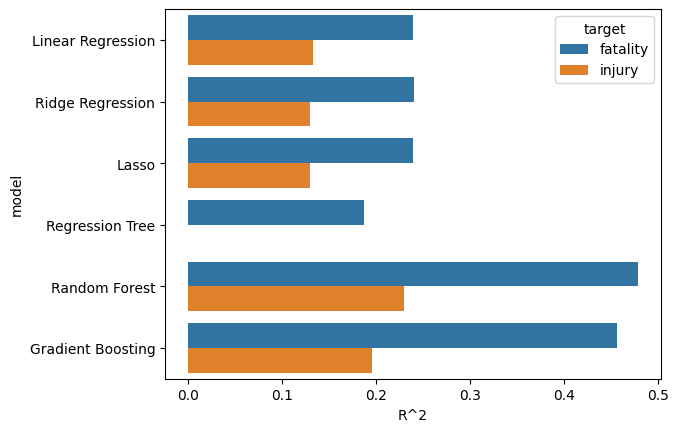

In [1778]:
sns.barplot(results_df, x="R^2", y="model", hue="target")

<b>We see that the more flexible random forest and gradient boosting offers better performance on the test data</b>